<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn


In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list -s "ovarian cancer"


ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
saurabhshahane/predict-ovarian-cancer                           Predict Ovarian Cancer                                   322564  2021-02-06 08:15:47.360000           2855         47  0.7058824        
yoshifumimiya/6-ovarian-cancer-datasets                         7 ovarian cancer datasets                             239456735  2024-04-21 13:37:49.933000           3464         48  0.7647059        
sunilthite/ovarian-cancer-classification-dataset                Ovarian Cancer Subtype Classification                3554471607  2023-10-31 08:34:17.390000           1515         38  1.0          

In [ ]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip



Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
import os

# List all files in the directory
os.listdir()


['.config', 'vgg19_ovarian_cancer_model.h5', 'OvarianCancer', 'sample_data']

In [ ]:
import os

# Check files inside the OvarianCancer folder
os.listdir("OvarianCancer")


['Non_Cancerous',
 'README.txt',
 'Clear_Cell',
 'Mucinous',
 'Endometri',
 'Serous']

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import preprocess_input

# Define dataset path
DATASET_PATH = "OvarianCancer"

# Define class names
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {class_name: i for i, class_name in enumerate(classes)}

# Define image size
IMG_SIZE = 224

# Lists to store images & labels
X, y = [], []

# Load images and labels dynamically
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)

    if not os.path.exists(class_path):
        continue  # Skip if folder doesn't exist

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip unreadable images

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)  # Preprocess for VGG19
        X.append(img)
        y.append(class_mapping[class_name])  # Assign label

# Convert lists to NumPy arrays
X = np.array(X)
y = to_categorical(y, num_classes=len(classes))  # One-hot encode labels

# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Dataset loaded: {len(X)} images")


✅ Dataset loaded: 497 images


In [23]:
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2  # For resizing images manually if needed

# Define image size (224x224 for the VGG19 input)
IMG_SIZE = 224

# Load pre-trained VGG19 model without the top layers
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers of VGG19
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the pre-trained base model
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(classes), activation="softmax")(x)  # Make sure len(classes) is defined

# Create the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

# Create ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True
)

# Train the model for 20 epochs using resized images
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,  # Increased number of epochs
    batch_size=8,  # Batch size (adjust as needed)
    verbose=1,
    callbacks=[lr_scheduler, checkpoint]
)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2972 - loss: 2.5212
Epoch 1: val_accuracy improved from -inf to 0.53000, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 329s 7s/step - accuracy: 0.2985 - loss: 2.5149 - val_accuracy: 0.5300 - val_loss: 1.5163 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5411 - loss: 1.5416
Epoch 2: val_accuracy improved from 0.53000 to 0.60000, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 403s 7s/step - accuracy: 0.5412 - loss: 1.5393 - val_accuracy: 0.6000 - val_loss: 1.0662 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6255 - loss: 1.0513
Epoch 3: val_accuracy improved from 0.60000 to 0.64000, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 358s 6s/step - accuracy: 0.6259 - loss: 1.0506 - val_accuracy: 0.6400 - val_loss: 0.9408 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6752 - loss: 0.9020
Epoch 4: val_accuracy improved from 0.64000 to 0.68000, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 338s 7s/step - accuracy: 0.6747 - loss: 0.9042 - val_accuracy: 0.6800 - val_loss: 0.9538 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7398 - loss: 0.7667
Epoch 5: val_accuracy improved from 0.68000 to 0.70000, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 382s 7s/step - accuracy: 0.7394 - loss: 0.7671 - val_accuracy: 0.7000 - val_loss: 0.8967 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7249 - loss: 0.8311
Epoch 6: val_accuracy did not improve from 0.70000
50/50 ━━━━━━━━━━━━━━━━━━━━ 321s 6s/step - accuracy: 0.7251 - loss: 0.8307 - val_accuracy: 0.7000 - val_loss: 0.8076 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7639 - loss: 0.6882
Epoch 7: val_accuracy improved from 0.70000 to 0.72000, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 338s 7s/step - accuracy: 0.7636 - loss: 0.6886 - val_accuracy: 0.7200 - val_loss: 0.8850 - learning_rate: 0.0010
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7510 - loss: 0.7330
Epoch 8: val_accuracy improved from 0.72000 to 0.75000, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 364s 6s/step - accuracy: 0.7512 - loss: 0.7324 - val_accuracy: 0.7500 - val_loss: 0.8786 - learning_rate: 0.0010
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7908 - loss: 0.6190
Epoch 9: val_accuracy did not improve from 0.75000
50/50 ━━━━━━━━━━━━━━━━━━━━ 343s 7s/step - accuracy: 0.7900 - loss: 0.6207 - val_accuracy: 0.7400 - val_loss: 0.8908 - learning_rate: 0.0010
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7707 - loss: 0.7194
Epoch 10: val_accuracy did not improve from 0.75000
50/50 ━━━━━━━━━━━━━━━━━━━━ 377s 7s/step - accuracy: 0.7702 - loss: 0.7211 - val_accuracy: 0.7300 - val_loss: 0.8818 - learning_rate: 0.0010
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7311 - loss: 0.6701
Epoch 11: val_accuracy did not improve from 0.75000
50/50 ━━━━━━━━━━━━━━━━━━━━ 382s 7s/step - accuracy: 0.7316 - loss: 0.6690 - val_accuracy: 0.6900 - val_loss: 0.9579 - learning_rate: 0.0010
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━

In [24]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Save model
model.save("vgg19_ovarian_cancer_model.h5")
print("Model saved successfully!")

4/4 ━━━━━━━━━━━━━━━━━━━━ 65s 15s/step - accuracy: 0.6923 - loss: 0.9487


Test Accuracy: 0.71
Model saved successfully!


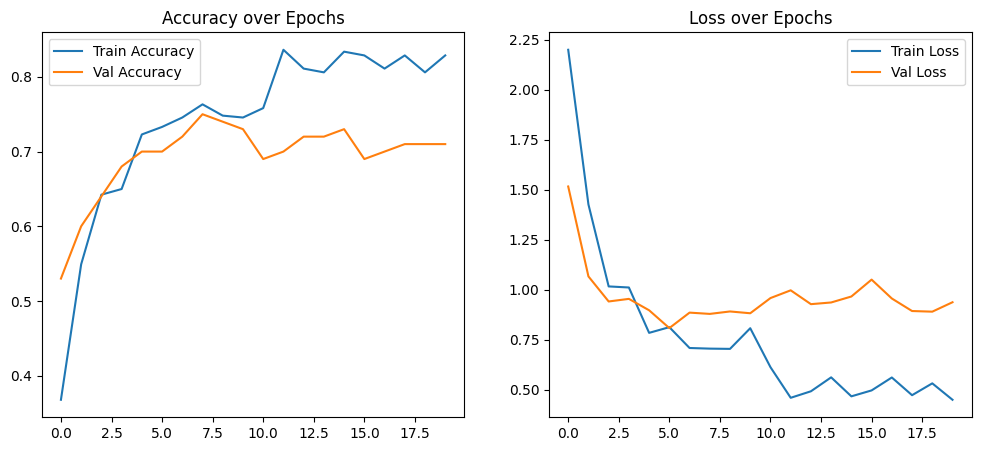

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.show()